In [1]:
import torch
import numpy as np
import pandas as pd
import time
import re
import os
import random
import sys
import yaml
import smart_open
import pickle
from PIL import Image
import cv2
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

### GPU 동작 확인

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


### 데이터  불러오기

In [3]:
# AIhub data
task_train_data = pd.read_csv(os.path.join('./dataset/task_train_info.csv'))
display(task_train_data.head())

# UTKFace data
UTK_data = pd.read_csv(os.path.join('./dataset/UTK_info.csv'))
display(UTK_data.head())

# wiki_crop data
wiki_data = pd.read_csv(os.path.join('./dataset/wiki_info.csv'))
display(wiki_data.head())

,path,gender,age
0,./dataset/task/train/Aihub1_00019651_Female_17...,1,17
1,./dataset/task/train/Aihub1_00019652_Female_17...,1,17
2,./dataset/task/train/Aihub1_00019653_Female_17...,1,17
3,./dataset/task/train/Aihub1_00019654_Female_17...,1,17
4,./dataset/task/train/Aihub1_00019655_Female_17...,1,17


,path,gender,age
0,./dataset/UTKFace/100_0_0_20170112213500903.jp...,0,100
1,./dataset/UTKFace/100_0_0_20170112215240346.jp...,0,100
2,./dataset/UTKFace/100_1_0_20170110183726390.jp...,1,100
3,./dataset/UTKFace/100_1_0_20170112213001988.jp...,1,100
4,./dataset/UTKFace/100_1_0_20170112213303693.jp...,1,100


,path,gender,age
0,./dataset/wiki_crop/17/10000217_1981-05-05_200...,1.0,28
1,./dataset/wiki_crop/12/100012_1948-07-03_2008.jpg,1.0,60
2,./dataset/wiki_crop/16/10002116_1971-05-31_201...,0.0,41
3,./dataset/wiki_crop/02/10002702_1960-11-09_201...,0.0,52
4,./dataset/wiki_crop/41/10003541_1937-09-27_197...,1.0,34


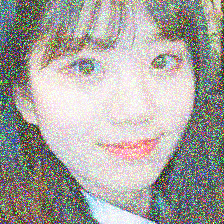

In [4]:
Image.open(task_train_data['path'][0])

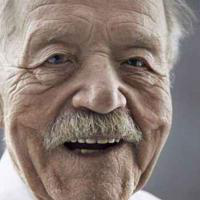

In [5]:
Image.open(UTK_data['path'][0])

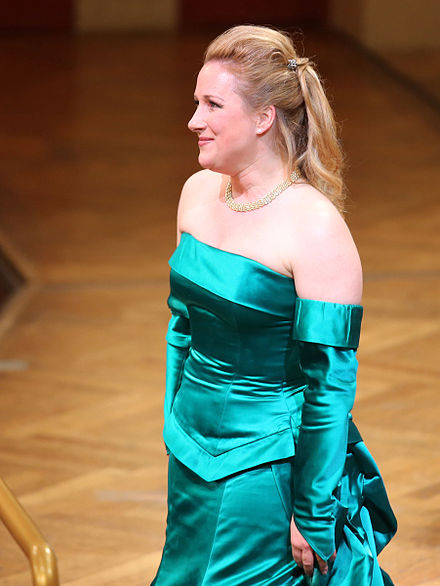

In [6]:
Image.open(wiki_data['path'][2])

In [7]:
def load_img_data(size, df):
    
    img_h, img_w = size, size
    imgs = []

    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        if (type(image_paths[i])==str):
            img = cv2.imread(image_paths[i])
        else:
            img = image_paths[i]

        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    # 원래 output 코드
    # return imgs, df['gender'].values, df['age'].values


    # 수정해야 할지도 모르는 부분 (age만 예측해서)
    # 나이를 원핫 인코딩 하여 classes를 지정해줌
    age_classes = 101 #(0, 100])
    target = df['age'].values
    target_classes = tf.keras.utils.to_categorical(target, age_classes)


    return imgs, target_classes

In [8]:
# # 이미지 불러오기

# print("Loading train images")
# x_train_imgs, y_train_gender, y_train_age = load_img_data(224, UTK_data.iloc[:500])

# print("Loading test images")
# x_test_imgs, y_test_gender, y_test_age = load_img_data(224, UTK_data.iloc[500:600])

In [9]:
# 이미지 불러오기

print("Loading train images")
X_train, y_train = load_img_data(224, UTK_data.iloc[:500])

print("Loading test images")
X_test, y_test = load_img_data(224, UTK_data.iloc[500:600])

train_data = (X_train, y_train)
test_data = (X_test, y_test)

Loading train images


100%|██████████| 500/500 [00:00<00:00, 1564.90it/s]


(500, 224, 224, 3)
Loading test images


100%|██████████| 100/100 [00:00<00:00, 1562.15it/s]

(100, 224, 224, 3)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold


class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(InceptionBlock, self).__init__()

        self.conv1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')

        self.conv3x3_reduce = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')
        self.conv3x3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')

        self.conv5x5_reduce = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')
        self.conv5x5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')

        self.pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')
        self.conv1x1pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')

    def call(self, x):
        conv1x1 = self.conv1x1(x)

        conv3x3_reduce = self.conv3x3_reduce(x)
        conv3x3 = self.conv3x3(conv3x3_reduce)

        conv5x5_reduce = self.conv5x5_reduce(x)
        conv5x5 = self.conv5x5(conv5x5_reduce)

        pool = self.pool(x)
        conv1x1pool = self.conv1x1pool(pool)

        inception_block = layers.concatenate([conv1x1, conv3x3, conv5x5, conv1x1pool], axis=-1)

        return inception_block
    

class GoogleNet(tf.keras.Model):
    def __init__(self, data, classes, epochs, batch_size):
        super(GoogleNet, self).__init__()
        self._input_shape = data[0][0].shape
        
        self.trainX = data[0]
        self.trainY = data[1]
        
        self.CLASSES = classes
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.train_generator = self.data_augmentation()

    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        return train_generator
    
    def train_process(self):
        self.model = self.build()
        self.model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
        
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=X_train.shape[0] // self.BATCH_SIZE,
            epochs=self.EPOCHS)
        
        print('\nPredicting test set classes.')
        score = self.model.evaluate(X_test, y_test, batch_size=self.BATCH_SIZE)
        print('Test set loss:', score[0], 'Test set ACC:', score[1])
    

    def build(self):
        # Define the network
        # 입력 레이어
        input_layer = layers.Input(shape=self._input_shape)

        # Convolutional layers
        x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
        x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

        # Inception blocks
        x = InceptionBlock([64, 96, 128, 16, 32, 32])(x)
        x = InceptionBlock([128, 128, 192, 32, 96, 64])(x)
        x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
        x = InceptionBlock([192, 96, 208, 16, 48, 64])(x)

        # Average pooling
        x = layers.GlobalAveragePooling2D()(x)

        # Fully connected layers
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        output = layers.Dense(7, activation='softmax')(x)

        # 모델 생성
        model = Model(inputs=input_layer, outputs=output)

        return model
    


In [12]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

CLASSES = 101
BATCH_SIZE = 128
EPOCHS = 20

model = GoogleNet(train_data, CLASSES, EPOCHS, BATCH_SIZE)

model.train_process()

Epoch 1/20


UnimplementedError: Graph execution error:

Detected at node 'model_1/conv2d_19/Relu' defined at (most recent call last):
    File "c:\Python\anaconda3\envs\CV\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Python\anaconda3\envs\CV\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Python\anaconda3\envs\CV\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Python\anaconda3\envs\CV\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Python\anaconda3\envs\CV\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ley21\AppData\Local\Temp\ipykernel_10676\256835643.py", line 12, in <module>
      model.train_process()
    File "C:\Users\ley21\AppData\Local\Temp\ipykernel_10676\3253793050.py", line 81, in train_process
      history = self.model.fit(
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Python\anaconda3\envs\CV\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_19/Relu'
DNN library is not found.
	 [[{{node model_1/conv2d_19/Relu}}]] [Op:__inference_train_function_5461]